In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import model_selection
from itertools import cycle

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler, LabelBinarizer

## LOAD DATA

In [2]:
# Load processed training and test data
!ls -al
!mkdir prognostic

from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/My\ Drive/MLProjects/Prognostic/data/*.csv /content/prognostic
! ls -al /content/prognostic

total 16
drwxr-xr-x 1 root root 4096 Aug 27 16:17 .
drwxr-xr-x 1 root root 4096 Sep  3 11:15 ..
drwxr-xr-x 1 root root 4096 Aug 28 16:06 .config
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
total 21116
drwxr-xr-x 2 root root     4096 Sep  3 11:23 .
drwxr-xr-x 1 root root     4096 Sep  3 11:23 ..
-rw------- 1 root root  2153095 Sep  3 11:23 test.csv
-rw------- 1 root root    78607 Sep  3 11:23 test_processed.csv
-rw------- 1 root root  3395968 Sep  3 11

In [3]:
df_train=pd.read_csv('prognostic/train_processed.csv')
df_test=pd.read_csv('prognostic/test_processed.csv')

display(df_train.head(3))
display(df_test.head(3))

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s1_av,s2_av,s3_av,s4_av,s5_av,s6_av,s7_av,s8_av,s9_av,s10_av,s11_av,s12_av,s13_av,s14_av,s15_av,s16_av,s17_av,s18_av,s19_av,s20_av,s21_av,s1_std,s2_std,s3_std,s4_std,s5_std,s6_std,s7_std,s8_std,s9_std,s10_std,s11_std,s12_std,s13_std,s14_std,s15_std,s16_std,s17_std,s18_std,s19_std,s20_std,s21_std,rul,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.06,9046.190000,1.3,47.47,521.66,2388.020,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.4190,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,518.67,641.985000,1590.760000,1401.870000,14.62,21.61,554.055000,2388.05,9045.130000,1.3,47.48,521.97,2388.045,8135.055000,8.425650,0.03,392.000000,2388.0,100.0,39.030000,23.4213,0.0,0.233345,1.499066,1.796051,0.0,0.0,0.431335,0.014142,1.499066,0.0,0.014142,0.438406,0.035355,5.041671,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,518.67,642.106667,1589.836667,1402.646667,14.62,21.61,554.123333,2388.06,9047.733333,1.3,47.41,522.12,2388.040,8134.446667,8.423033,0.03,391.333333,2388.0,100.0,39.003333,23.3956,0.0,0.267644,1.918654,1.850009,0.0,0.0,0.327159,0.020000,4.632023,0.0,0.121655,0.404475,0.026458,3.717450,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s1_av,s2_av,s3_av,s4_av,s5_av,s6_av,s7_av,s8_av,s9_av,s10_av,s11_av,s12_av,s13_av,s14_av,s15_av,s16_av,s17_av,s18_av,s19_av,s20_av,s21_av,s1_std,s2_std,s3_std,s4_std,s5_std,s6_std,s7_std,s8_std,s9_std,s10_std,s11_std,s12_std,s13_std,s14_std,s15_std,s16_std,s17_std,s18_std,s19_std,s20_std,s21_std,rul,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,47.23,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,518.67,642.44,1584.696667,1399.330000,14.62,21.61,554.223333,2388.083333,9049.986667,1.3,47.350000,521.986667,2388.076667,8132.676667,8.411533,0.03,392.000000,2388.0,100.0,38.973333,23.374733,0.0,0.437150,3.094614,1.475534,0.0,0.0,0.172143,0.005774,5.594375,0.0,0.104403,0.349333,0.020817,2.372706,0.009411,0.0,1.00000,0.0,0.0,0.145717,0.028070,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,47.67,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618,518.67,642.68,1587.293333,1408.673333,14.62,21.61,553.686667,2388.113333,9047.940000,1.3,47.536667,521.763333,2388.103333,8127.106667,8.439700,0.03,391.666667,2388.0,100.0,38.893333,23.283367,0.0,0.153948,0.612563,4.747803,0.0,0.0,0.491664,0.061101,3.917742,0.0,0.119304,0.455448,0.011547,1.570234,0.015373,0.0,0.57735,0.0,0.0,0.090738,0.018825,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,47.88,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740,518.67,643.06,1589.626667,1414.756667,14.62,21.61,552.663333,2388.160000,9048.406667,1.3,47.703333,520.610000,2388.170000,8131.030000,8.442600,0.03,394.666667,2388.0,100.0,38.723333,23.245433,0.0,0.180000,0.931146,3.580703,0.0,0.0,0.405010,0.030000,0.752152,0.0,0.153080,0.416173,0.036056,2.819699,0.026739,0.0,0.57735,0.0,0.0,0.188768,0.025085,69,0,0


In [0]:
#Create Training and Test data label series and Create the list of Original Feature (-constant features) and List of Original+Added Feature (-constant features)
original_sensor_features = ['setting1', 'setting2', 'setting3', 's1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20', 's21']
constant_sensor_features = ['setting3','s1', 's5' , 's6', 's10', 's16', 's18', 's19']


variable_sensor_features = ['setting1', 'setting2', 's2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20', 's21']
variable_sensor_features_fx= ['setting1', 'setting2', 's2', 's3', 's4',
       's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20',
       's21', 's2_av', 's3_av', 's4_av', 's7_av', 's8_av', 's9_av', 's11_av',
       's12_av', 's13_av', 's14_av', 's15_av', 's17_av', 's20_av', 's21_av',
       's2_std', 's3_std', 's4_std', 's7_std', 's8_std', 's9_std', 's11_std',
       's12_std', 's13_std', 's14_std', 's15_std', 's17_std', 's20_std',
       's21_std']

X_train = df_train[variable_sensor_features]
X_train_fx = df_train[variable_sensor_features_fx]

X_test = df_test[variable_sensor_features]
X_test_fx = df_test[variable_sensor_features_fx]

y_train = df_train['label_mcc']
y_test = df_test['label_mcc']

In [0]:
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

## MULTI CLASS CLASSIFICATION

Let's start by adding helper functions

In [0]:
def multiclass_classify(model, clf, X_train, X_test, y_train, y_test, params=None, score=None, scale=False, OvR=True, prob='P'):
  """
  Perfrom Grid Search Hyper Parameter Tuning on a Classifier
  
  Args:
  model(str)              : Name / Identifier for the model
  clf(classifier obj)     : The classifier to be tuned
  X_train                 : training features
  X_test                  : test dataset features
  y_train                 : training dataset labels
  y_test                  : test dataset labels
  OvR(boolean)            : True - if classifier inherently supports multiclass classifier
  prob(str)               : For getting classification score: P -> predict_prob, 'D' for decision_functions
  
  Returns:
  Tuned Classifier Object
  Array of Prediction Values
  Array of Prediction Scores
  """
  grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)
  grid_search.fit(X_train, y_train)
  y_pred = grid_search.predict(X_test)
  
  if prob=='P':
    y_score = grid_search.predict_proba(X_test)
    if OvR:
      y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
      y_score = np.concatenate(y_score, axis=1)
  elif prob == 'D':
    y_score = grid_search.decision_function(X_test)
  else:
    y_score = y_pred
    
  return grid_search.best_estimator_, y_pred, y_score
    
  

In [0]:
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
  """
  Calculate main multiclass classification metrices, plot AUC-ROC and Precision-Recall curves
  Args:
        model(str)        : Name / Identifier of the mode
        y_test(series)    : Contains the test label values
        y_pred(series)    : Contains the Predicted Values
        y_score(series)   : Contains the Predictions Scores
        print_out(bool)   : Print the Classification Metrics and Thresholds Values
        plot_out(bool)    : Plot AUC_ROC, Precision-Recall and Threshold Curves
        
  Returns
       dataframe: the combined metrics in one fram
       dict:              : ROC Thresholds
       dict               : Precision-Recall Thresholds
       Plot               : AUC ROC
       Plot               : Precision Recall
   """
  
  
  multiclass_metrics={'Accuracy': metrics.accuracy_score(y_test, y_pred),
                     'Macro F1': metrics.f1_score(y_test, y_pred, average='macro'),
                     'Micro F1': metrics.f1_score(y_test, y_pred, average='micro'),
                     'Macro Precision': metrics.precision_score(y_test, y_pred, average='macro'),
                     'Micro Precision': metrics.precision_score(y_test, y_pred, average='micro'),
                     'Macro Recall': metrics.recall_score(y_test, y_pred, average='macro'),
                     'Micro Recall': metrics.recall_score(y_test, y_pred, average='micro'),
                     'Macro ROC AUC': metrics.roc_auc_score(y_test, y_score, average='macro'),
                     'Micro ROC AUC': metrics.roc_auc_score(y_test, y_score, average='micro')}
  
  df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
  df_metrics.columns = [model]
  
  n_classes = y_train.shape[1]
  
  fpr = dict()
  tpr = dict()
  thresh_roc = dict()
  roc_auc = dict()
  
  for i in range(n_classes):
    fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
  
  fpr['micro'], tpr['micro'], thresh_roc['micro'] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc['micro'] = metrics.auc(fpr['micro'], tpr['micro'])
  
  roc_thresh = {'Threshold': thresh_roc,
               'TPR': tpr,
               'FPR': fpr,
               'AUC': roc_auc}
  
  df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
  df_roc_thresh['Model'] = model
  df_roc_thresh['Class'] = df_roc_thresh.index
  
  
  precision = dict()
  recall = dict()
  thresh_prc = dict()
  average_precision = dict()
  
  for i in range(n_classes):
    precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:,i])
    average_precision[i] = metrics.average_precision_score(y_test[:,i], y_score[:,i])
    precision['micro'], recall['micro'], thresh_prc['micro'] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision['micro'] = metrics.average_precision_score(y_test, y_pred, average='micro')
    
  prc_thresh = {
      'Threshold': thresh_prc,
      'Precision': precision,
      'Recall': recall,
      'Avg Precision': average_precision
  }
  
  df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
  df_prc_thresh['Model'] = model
  df_prc_thresh['Class'] = df_prc_thresh.index
  
  y_test_orig = lb.inverse_transform(y_test)
  y_pred_orig = lb.inverse_transform(y_pred)
  
  if print_out:
    print('----------------------------------------------')
    print(model,'\n')
    print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
    print('Classification Report:')
    print(metrics.classification_report(y_test_orig, y_pred_orig))
    print('\nMetrics')
    print(df_metrics)
    
  
  if plot_out:
    colors=cycle(['red', 'green', 'blue'])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
    fig.set_size_inches(12,6)
    
    for i, color in zip(range(n_classes), colors):
      ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC Curve of Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    ax1.plot(fpr['micro'], tpr['micro'], color='deeppink', label='Micro Average ROC Curve (area = {0:0.2f})'.format(roc_auc['micro']), linestyle=':', linewidth=4)
    ax1.plot([0,1], [0,1], color='navy', linestyle='--')
    ax1.set_xlim([-0.05, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(loc='lower right', fontsize='small')
    
    
    for i, color in zip(range(n_classes), colors):
      ax2.plot(recall[i], precision[i], color=color, lw=1, label='Precision Recall Curve of Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend(loc='lower left', fontsize='small')
    
    return df_metrics, df_roc_thresh, df_prc_thresh

Using the above helper functions we will now model various classification algorithms. For every classification algorithm we will evalute with original features as well as dataset with extracted additional features and use the following convention

**<model>_B** - with original feature sets
  
**<model>_A** - after feature engineering 
  
  
We will evalute following classification algorithms
* Logistic Regression
* Linear SVC
* Gaussian NB
* KNN
* Random Forest
* Neural Net

### Logistic Regression


Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
----------------------------------------------
Logistic Regression B 

[[75  0  0]
 [14  0  1]
 [ 2  0  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        75
           1       0.00      0.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


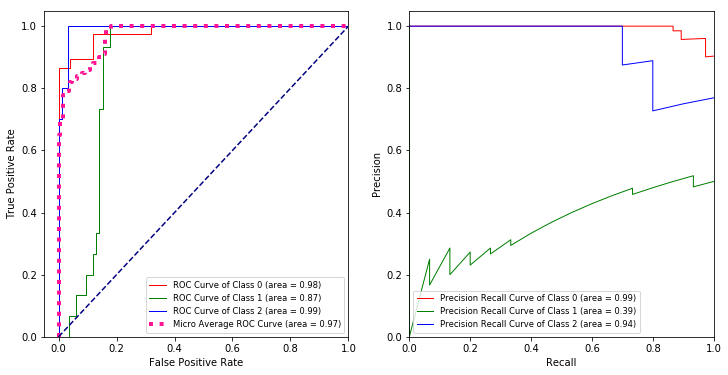

In [8]:
model = 'Logistic Regression B'

clf_lgrb = OneVsRestClassifier(LogisticRegression(random_state=123, max_iter=1000))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgrb, y_pred_lgrb, y_score_lgrb = multiclass_classify(model, clf_lgrb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, roc_lgrb, prc_lgrb = multiclass_metrics(model, y_test, y_pred_lgrb, y_score_lgrb, print_out=True, plot_out=True)


Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
----------------------------------------------
Logistic Regression A 

[[75  0  0]
 [14  0  1]
 [ 2  0  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        75
           1       0.00      0.00   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


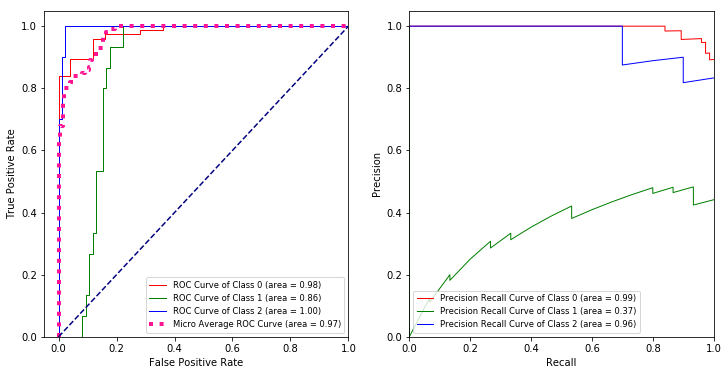

In [9]:
model = 'Logistic Regression A'

clf_lgra = OneVsRestClassifier(LogisticRegression(random_state=123, max_iter=1000))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgra, y_pred_lgra, y_score_lgra = multiclass_classify(model, clf_lgra, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgra, roc_lgra, prc_lgra = multiclass_metrics(model, y_test, y_pred_lgra, y_score_lgra, print_out=True, plot_out=True)

In [10]:
metrics_lgr = pd.concat([metrics_lgrb, metrics_lgra], axis=1)
metrics_lgr

,Logistic Regression B,Logistic Regression A
Accuracy,0.830000,0.820000
Macro F1,0.597157,0.596941
Micro F1,0.864583,0.863158
Macro Precision,0.597501,0.600823
Micro Precision,0.902174,0.911111
Macro Recall,0.600000,0.595556
Micro Recall,0.830000,0.820000
Macro ROC AUC,0.948393,0.945572
Micro ROC AUC,0.972900,0.974550


### Linear SVC

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr


Best Parameters:
 OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=123, tol=0.0001,
                                        verbose=0),
                    n_jobs=None)
----------------------------------------------
SVC Linear B 

[[75  0  0]
 [13  0  2]
 [ 4  0  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        75
           1       0.00      0.00      0.00        15
           2       0.75      0.60      0.67        10

    accuracy                           0.81       100
   macro avg       0.52      0.53      0.52       100
weighted avg       0.69      0.81      0.74       100


Metrics
      

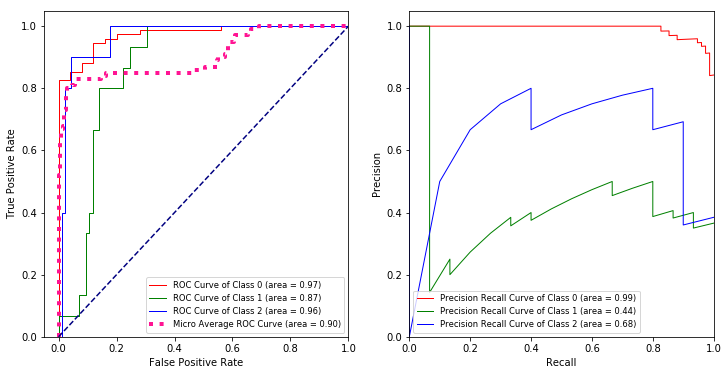

In [11]:
model = 'SVC Linear B'

clf_svlb = OneVsRestClassifier(LinearSVC(random_state=123, max_iter=1000))
gs_params = {'estimator__C': [.01, 0.1, 1.0]}
gs_score = 'roc_auc'


clf_svlb, y_pred_svlb, y_score_svlb = multiclass_classify(model, clf_svlb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score, scale=False, OvR=False, prob='D')
print('\nBest Parameters:\n',clf_svlb)

metrics_svlb, roc_svlb, prc_svlb = multiclass_metrics(model, y_test, y_pred_svlb, y_score_svlb, print_out=True, plot_out=True)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr


Best Parameters:
 OneVsRestClassifier(estimator=LinearSVC(C=0.1, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=123, tol=0.0001,
                                        verbose=0),
                    n_jobs=None)
----------------------------------------------
SVC Linear A 

[[75  0  0]
 [15  0  0]
 [10  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        75
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        10

    accuracy                           0.75       100
   macro avg       0.25      0.33      0.29       100
weighted avg       0.56      0.75      0.64       100


Metrics
      

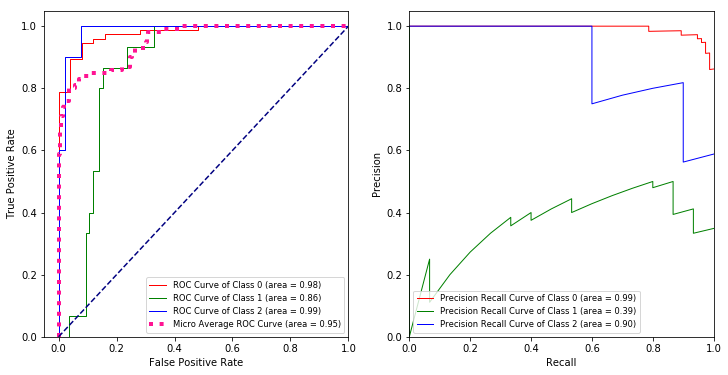

In [12]:
model = 'SVC Linear A'

clf_svla = OneVsRestClassifier(LinearSVC(random_state=123, max_iter=1000))
gs_params = {'estimator__C': [.01, 0.1, 1.0]}
gs_score = 'roc_auc'


clf_svla, y_pred_svla, y_score_svla = multiclass_classify(model, clf_svla,  X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score, scale=False, OvR=False, prob='D')
print('\nBest Parameters:\n',clf_svla)

metrics_svla, roc_svla, prc_svla = multiclass_metrics(model, y_test, y_pred_svla, y_score_svla, print_out=True, plot_out=True)

In [13]:
metrics_svl = pd.concat([metrics_svlb, metrics_svla], axis=1)
metrics_svl

,SVC Linear B,SVC Linear A
Accuracy,0.650000,0.620000
Macro F1,0.430120,0.299517
Micro F1,0.729614,0.760736
Macro Precision,0.353040,0.328042
Micro Precision,0.639098,0.984127
Macro Recall,0.666667,0.275556
Micro Recall,0.850000,0.620000
Macro ROC AUC,0.934898,0.942490
Micro ROC AUC,0.903950,0.950900


### Gaussian NB


Best Parameters:
 OneVsRestClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                    n_jobs=None)
----------------------------------------------
Gaussian NB B 

[[71  4  0]
 [ 2 13  0]
 [ 0 10  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        75
           1       0.48      0.87      0.62        15
           2       0.00      0.00      0.00        10

    accuracy                           0.84       100
   macro avg       0.48      0.60      0.53       100
weighted avg       0.80      0.84      0.81       100


Metrics
                 Gaussian NB B
Accuracy              0.760000
Macro F1              0.754885
Micro F1              0.854545
Macro Precision       0.658811
Micro Precision       0.783333
Macro Recall          0.937778
Micro Recall          0.940000
Macro ROC AUC         0.950334
Micro ROC AUC         0.965350


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


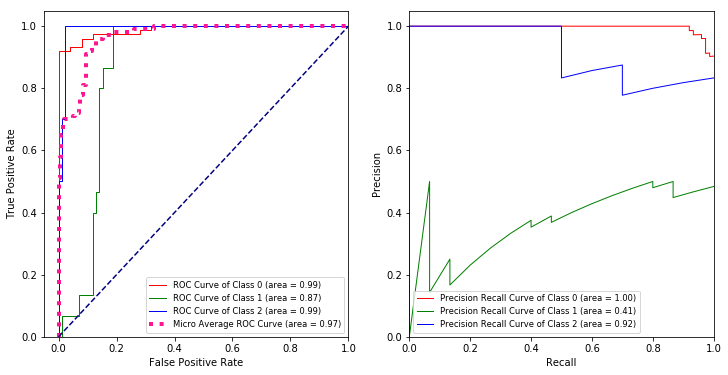

In [14]:
model = 'Gaussian NB B'
clf_gnbb = OneVsRestClassifier(GaussianNB())
gs_params = {} 
gs_score = 'roc_auc'


clf_gnbb, y_pred_gnbb, y_score_gnbb = multiclass_classify(model, clf_gnbb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n', clf_gnbb)

metrics_gnbb, roc_gnbb, prc_gnbb = multiclass_metrics(model, y_test, y_pred_gnbb, y_score_gnbb, print_out=True, plot_out=True)


Best Parameters:
 OneVsRestClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                    n_jobs=None)
----------------------------------------------
Gaussian NB A 

[[70  5  0]
 [ 2 13  0]
 [ 0 10  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        75
           1       0.46      0.87      0.60        15
           2       0.00      0.00      0.00        10

    accuracy                           0.83       100
   macro avg       0.48      0.60      0.52       100
weighted avg       0.80      0.83      0.80       100


Metrics
                 Gaussian NB A
Accuracy              0.740000
Macro F1              0.754954
Micro F1              0.849315
Macro Precision       0.664502
Micro Precision       0.781513
Macro Recall          0.933333
Micro Recall          0.930000
Macro ROC AUC         0.944855
Micro ROC AUC         0.950325


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


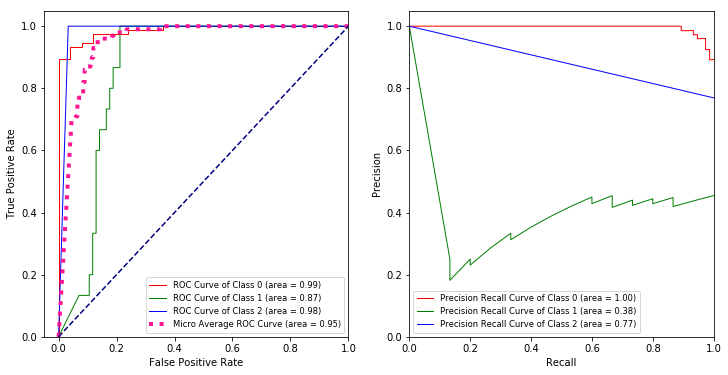

In [15]:
model = 'Gaussian NB A'
clf_gnba = OneVsRestClassifier(GaussianNB())
gs_params = {} 
gs_score = 'roc_auc'


clf_gnba, y_pred_gnba, y_score_gnba = multiclass_classify(model, clf_gnba, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n', clf_gnba)

metrics_gnba, roc_gnba, prc_gnba = multiclass_metrics(model, y_test, y_pred_gnba, y_score_gnba, print_out=True, plot_out=True)

In [16]:
metrics_gnb = pd.concat([metrics_gnbb, metrics_gnba], axis=1)
metrics_gnb

,Gaussian NB B,Gaussian NB A
Accuracy,0.760000,0.740000
Macro F1,0.754885,0.754954
Micro F1,0.854545,0.849315
Macro Precision,0.658811,0.664502
Micro Precision,0.783333,0.781513
Macro Recall,0.937778,0.933333
Micro Recall,0.940000,0.930000
Macro ROC AUC,0.950334,0.944855
Micro ROC AUC,0.965350,0.950325


### KNN


Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='uniform')
----------------------------------------------
KNN B 

[[75  0  0]
 [10  3  2]
 [ 3  1  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        75
           1       0.75      0.20      0.32        15
           2       0.75      0.60      0.67        10

    accuracy                           0.84       100
   macro avg       0.78      0.60      0.63       100
weighted avg       0.83      0.84      0.80       100


Metrics
                    KNN B
Accuracy         0.830000
Macro F1         0.641710
Micro F1         0.855670
Macro Precision  0.800813
Micro Precision  0.882979
Macro Recall     0.595556
Micro Recall     0.830000
Macro ROC AUC    0.904947
Micro ROC AUC    0.954825


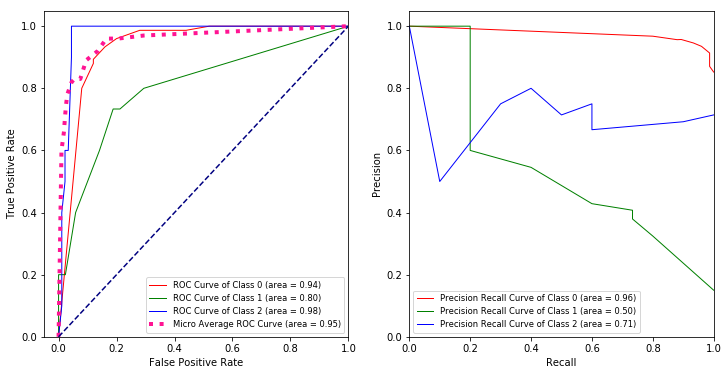

In [17]:
model = 'KNN B'
clf_knnb = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'


clf_knnb, y_pred_knnb, y_score_knnb = multiclass_classify(model, clf_knnb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n', clf_knnb)

metrics_knnb, roc_knnb, prc_knnb = multiclass_metrics(model, y_test, y_pred_knnb, y_score_knnb, print_out=True, plot_out=True)


Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='uniform')
----------------------------------------------
KNN A 

[[74  1  0]
 [ 9  5  1]
 [ 1  2  7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        75
           1       0.62      0.33      0.43        15
           2       0.88      0.70      0.78        10

    accuracy                           0.86       100
   macro avg       0.79      0.67      0.71       100
weighted avg       0.84      0.86      0.84       100


Metrics
                    KNN A
Accuracy         0.860000
Macro F1         0.720426
Micro F1         0.873096
Macro Precision  0.804527
Micro Precision  0.886598
Macro Recall     0.673333
Micro Recall     0.860000
Macro ROC AUC    0.948197
Micro ROC AUC    0.973225


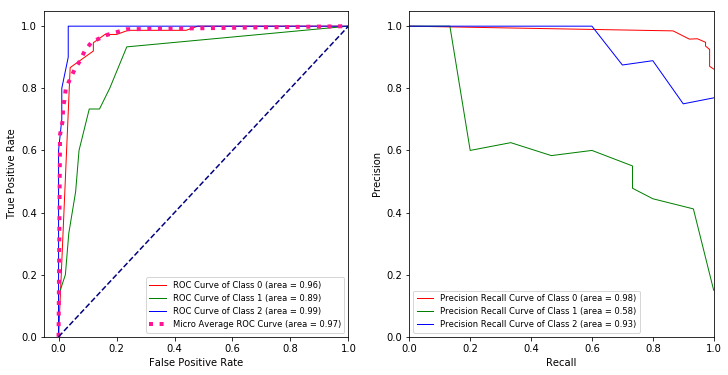

In [18]:
model = 'KNN A'
clf_knna = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'


clf_knna, y_pred_knna, y_score_knna = multiclass_classify(model, clf_knna, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n', clf_knna)

metrics_knna, roc_knna, prc_knna = multiclass_metrics(model, y_test, y_pred_knna, y_score_knna, print_out=True, plot_out=True)

In [19]:
metrics_knn = pd.concat([metrics_knnb, metrics_knna], axis=1)
metrics_knn

,KNN B,KNN A
Accuracy,0.830000,0.860000
Macro F1,0.641710,0.720426
Micro F1,0.855670,0.873096
Macro Precision,0.800813,0.804527
Micro Precision,0.882979,0.886598
Macro Recall,0.595556,0.673333
Micro Recall,0.830000,0.860000
Macro ROC AUC,0.904947,0.948197
Micro ROC AUC,0.954825,0.973225


### Random Forest


Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
----------------------------------------------
Random Forest B 

[[75  0  0]
 [12  1  2]
 [ 3  0  7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        75
           1       1.00      0.07      0.12        15
           2       0.78      0.70      0.74        10

    accuracy                           0.83       100
   macro avg       0.87      0.59      0.59       100
weighted avg       0.85      0.83      0.

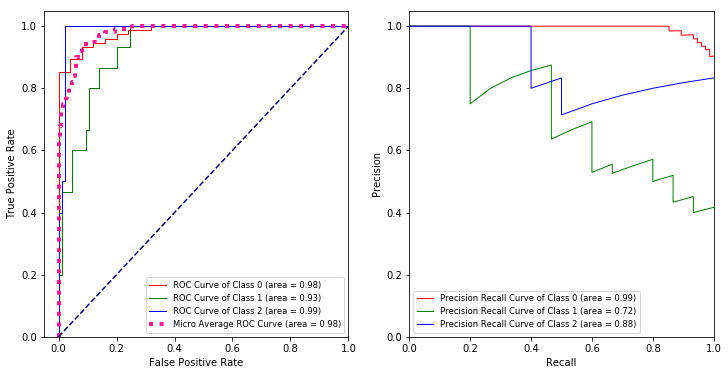

In [20]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfcb, y_pred_rfcb, y_score_rfcb = multiclass_classify(model, clf_rfcb,  X_train, X_test, y_train, y_test, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, roc_rfcb, prc_rfcb = multiclass_metrics(model, y_test, y_pred_rfcb, y_score_rfcb, print_out=True, plot_out=True)


Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
----------------------------------------------
Random Forest A 

[[74  1  0]
 [ 9  5  1]
 [ 2  0  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.83      0.33      0.48        15
           2       0.89      0.80      0.84        10

    accuracy                           0.87       100
   macro avg       0.86      0.71      0.75       100
weighted avg       0.87      0.87      0.

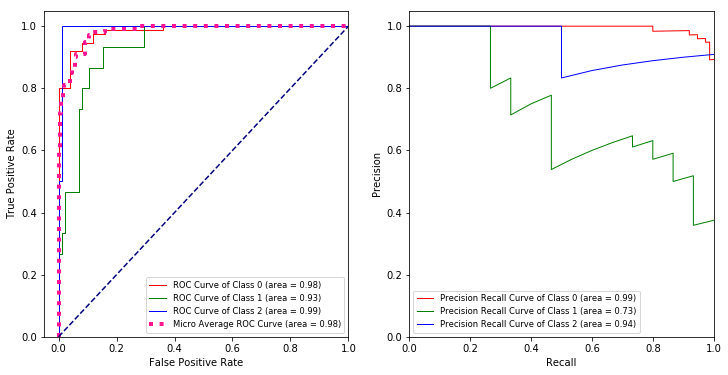

In [21]:
model = 'Random Forest A'
clf_rfca = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfca, y_pred_rfca, y_score_rfca = multiclass_classify(model, clf_rfca,  X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfca, roc_rfca, prc_rfca = multiclass_metrics(model, y_test, y_pred_rfca, y_score_rfca, print_out=True, plot_out=True)

In [22]:
metrics_rfc = pd.concat([metrics_rfcb, metrics_rfca], axis=1)
metrics_rfc

,Random Forest B,Random Forest A
Accuracy,0.820000,0.870000
Macro F1,0.603520,0.755671
Micro F1,0.858639,0.887755
Macro Precision,0.897119,0.878601
Micro Precision,0.901099,0.906250
Macro Recall,0.584444,0.706667
Micro Recall,0.820000,0.870000
Macro ROC AUC,0.966697,0.970760
Micro ROC AUC,0.979050,0.982200


### Neural Net


Best Parameters:
 MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=123, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
----------------------------------------------
Neural Net MLP B 

[[75  0  0]
 [15  0  0]
 [10  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        75
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        10

    accuracy                           0.75       100
   macro avg       0.25      0.33      0.29       100
weighted avg       0.56      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


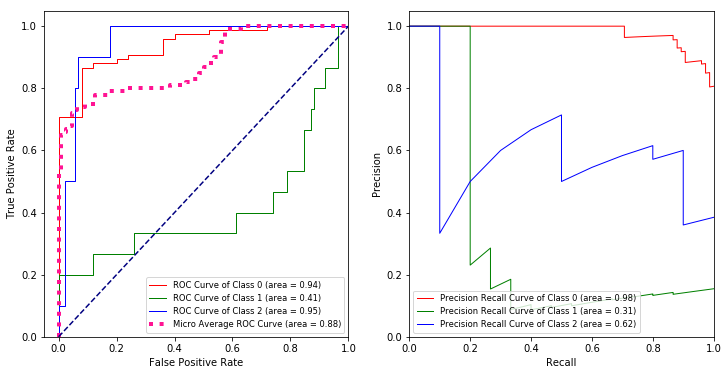

In [23]:
model = 'Neural Net MLP B'
clf_nncb = MLPClassifier(solver='adam', random_state=123)
gs_params = {'alpha': [0.001, 0.01], 'hidden_layer_sizes': [(100,), (100,100)]}
gs_score = 'roc_auc'


clf_nncb, y_pred_nncb, y_score_nncb = multiclass_classify(model, clf_nncb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score, scale=True, OvR=False)
print('\nBest Parameters:\n',clf_nncb)

metrics_nncb, roc_nncb, prc_nncb = multiclass_metrics(model, y_test, y_pred_nncb, y_score_nncb, print_out=True, plot_out=True)


Best Parameters:
 MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=123, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
----------------------------------------------
Neural Net MLP A 

[[75  0  0]
 [15  0  0]
 [10  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        75
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        10

    accuracy                           0.75       100
   macro avg       0.25      0.33      0.29       100
weighted avg       0.56      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


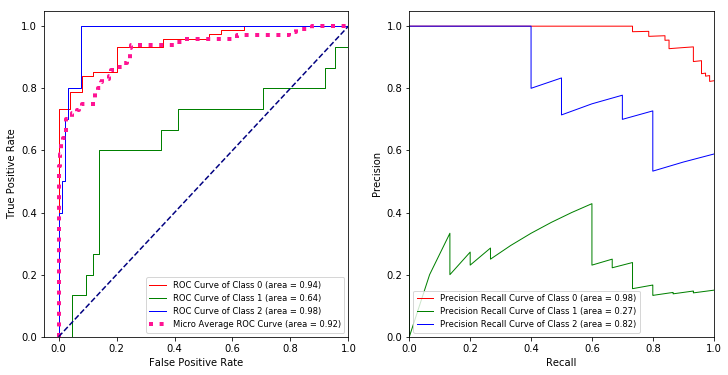

In [24]:
model = 'Neural Net MLP A'
clf_nnca = MLPClassifier(solver='adam', random_state=123)
gs_params = {'alpha': [0.001, 0.01], 'hidden_layer_sizes': [(100,), (100,100)]}
gs_score = 'roc_auc'


clf_nnca, y_pred_nnca, y_score_nnca = multiclass_classify(model, clf_nnca, X_train_fx, X_test_fx, y_train, y_test, params=gs_params, score=gs_score, scale=True, OvR=False)
print('\nBest Parameters:\n',clf_nnca)

metrics_nnca, roc_nnca, prc_nnca = multiclass_metrics(model, y_test, y_pred_nnca, y_score_nnca, print_out=True, plot_out=True)

In [25]:
metrics_nnc = pd.concat([metrics_nncb, metrics_nnca], axis=1)
metrics_nnc

,Neural Net MLP B,Neural Net MLP A
Accuracy,0.750000,0.750000
Macro F1,0.285714,0.285714
Micro F1,0.750000,0.750000
Macro Precision,0.250000,0.250000
Micro Precision,0.750000,0.750000
Macro Recall,0.333333,0.333333
Micro Recall,0.750000,0.750000
Macro ROC AUC,0.767072,0.854053
Micro ROC AUC,0.880800,0.920400


### Compare Multi class Classification Algorithms

In [26]:
#compare all models
metrics_mc = pd.concat([metrics_lgr, metrics_svl, metrics_gnb, metrics_knn, metrics_rfc, metrics_nnc], axis=1).T
metrics_mc

,Accuracy,Macro F1,Micro F1,Macro Precision,Micro Precision,Macro Recall,Micro Recall,Macro ROC AUC,Micro ROC AUC
Logistic Regression B,0.83,0.597157,0.864583,0.597501,0.902174,0.600000,0.83,0.948393,0.972900
Logistic Regression A,0.82,0.596941,0.863158,0.600823,0.911111,0.595556,0.82,0.945572,0.974550
SVC Linear B,0.65,0.430120,0.729614,0.353040,0.639098,0.666667,0.85,0.934898,0.903950
SVC Linear A,0.62,0.299517,0.760736,0.328042,0.984127,0.275556,0.62,0.942490,0.950900
Gaussian NB B,0.76,0.754885,0.854545,0.658811,0.783333,0.937778,0.94,0.950334,0.965350
Gaussian NB A,0.74,0.754954,0.849315,0.664502,0.781513,0.933333,0.93,0.944855,0.950325
KNN B,0.83,0.641710,0.855670,0.800813,0.882979,0.595556,0.83,0.904947,0.954825
KNN A,0.86,0.720426,0.873096,0.804527,0.886598,0.673333,0.86,0.948197,0.973225
Random Forest B,0.82,0.603520,0.858639,0.897119,0.901099,0.584444,0.82,0.966697,0.979050
Random Forest A,0.87,0.755671,0.887755,0.878601,0.906250,0.706667,0.87,0.970760,0.982200


Neural Net Multi-layer Perceptron classifier clearly outperformed other models in all metrics, with the Random Forests classifier scoring in the second place.

Text(0.5, 1.0, 'micro Precision Recall')

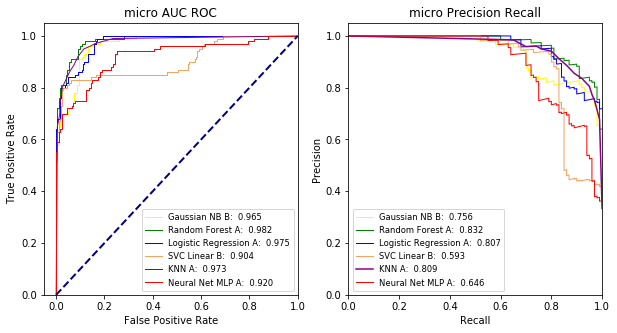

In [27]:
# Plot AUC-ROC and precision-recall curves for best models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)

ax1.plot(roc_gnbb.FPR['micro'], roc_gnbb.TPR['micro'], color='yellow', lw=1, label= roc_gnbb.Model['micro'] + ':  %.3f' % roc_gnbb.AUC['micro'])
ax1.plot(roc_rfca.FPR['micro'], roc_rfca.TPR['micro'], color='green', lw=1, label= roc_rfca.Model['micro'] + ':  %.3f' % roc_rfca.AUC['micro'])
ax1.plot(roc_lgra.FPR['micro'], roc_lgra.TPR['micro'], color='blue', lw=1, label= roc_lgra.Model['micro'] + ':  %.3f' % roc_lgra.AUC['micro'])
ax1.plot(roc_svlb.FPR['micro'], roc_svlb.TPR['micro'], color='sandybrown', lw=1, label= roc_svlb.Model['micro'] + ':  %.3f' % roc_svlb.AUC['micro'])
ax1.plot(roc_knna.FPR['micro'], roc_knna.TPR['micro'], color='darkmagenta', lw=1, label= roc_knna.Model['micro'] + ':  %.3f' % roc_knna.AUC['micro'])
ax1.plot(roc_nnca.FPR['micro'], roc_nnca.TPR['micro'], color='red', lw=1, label= roc_nnca.Model['micro'] + ':  %.3f' % roc_nnca.AUC['micro'])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('micro AUC ROC')

ax2.plot(prc_gnbb.Recall['micro'], prc_gnbb.Precision['micro'], color='yellow', lw=1, label= prc_gnbb.Model['micro'] + ':  %.3f' % prc_gnbb['Avg Precision']['micro'])
ax2.plot(prc_rfca.Recall['micro'], prc_rfca.Precision['micro'], color='green', lw=1, label= prc_rfca.Model['micro'] + ':  %.3f' % prc_rfca['Avg Precision']['micro'])
ax2.plot(prc_lgra.Recall['micro'], prc_lgra.Precision['micro'], color='blue', lw=1, label= prc_lgra.Model['micro'] + ':  %.3f' % prc_lgra['Avg Precision']['micro'])
ax2.plot(prc_svlb.Recall['micro'], prc_svlb.Precision['micro'], color='sandybrown', lw=1, label= prc_svlb.Model['micro'] + ':  %.3f' % prc_svlb['Avg Precision']['micro'])
ax2.plot(prc_knna.Recall['micro'], prc_knna.Precision['micro'], color='darkmagenta', label= prc_knna.Model['micro'] + ':  %.3f' % prc_knna['Avg Precision']['micro'])
ax2.plot(prc_nnca.Recall['micro'], prc_nnca.Precision['micro'], color='red', lw=1, label= prc_nnca.Model['micro'] + ':  %.3f' % prc_nnca['Avg Precision']['micro'])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('micro Precision Recall')

The graph shows that Naive Bayes and Random Forest are top two performing models in both AUC ROC and Precision-Recall curves.